# Parte 2: Clasificación con RNR - LSTM

Arquitectura a usar con una RNN para clasificación :

    1- Sequence Input
    2- LSTM
    3- Fully-connected layer
    4- Softmax
    5- Classification output
    
Most LSTM/RNN diagrams just show the hidden cells but never the units of those cells. Hence, the confusion. Each hidden layer has hidden cells, as many as the number of time steps. And further, each hidden cell is made up of multiple hidden units, like in the diagram below. Therefore, the dimensionality of a hidden layer matrix in RNN is (number of time steps, number of hidden units). (https://datascience.stackexchange.com/questions/12964/what-is-the-meaning-of-the-number-of-units-in-the-lstm-cell ) 

Observamos overfitting en la gráfica. Además:
    
    loss = 0.01
    accuracy = 0.999 
    val_loss = 2.09
    val_accuracy = 0.68
    
Por tanto: 

    Etrain = 1-0.999 = 0.001
    Etest = 1- 0.68 = 0.32
    
    Bias = Etrain - Ehuman = 0.001
    Variance = Etest - Etrain = 0.32 - 0.001 = 0.31
    
La varianza es alta, debemos tratar de reducirla: añadiendo más datos, regularizando, probando una arquitectura diferente...
			

### 1 - Import Libraries

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


### 2 - Load data

In [3]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [4]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    #mdata = mat['output']
    #val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(mat["task"]), np.array(mat["data"]))
    return output

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
user = '0091' # SE PUEDE CAMBIAR

lTaskData = []
for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        
        if task3 != "":
            outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
        else: 
            outT = (output.task == task1) | (output.task == task2)
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)

# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev = [],[],[],[] 
for j in range(0,total_records-2): # Cogemos 2 registros para entrenamiento
    X_train.extend(lTaskData[j].data)
    y_train.extend(lTaskData[j].task)
    
X_dev.extend(lTaskData[total_records-2].data) # Cogemos un registro para el dev set
y_dev.extend(lTaskData[total_records-2].task)

X_train = np.array(X_train)
y_train = np.ravel(np.array(y_train))
X_dev = np.array(X_dev)
y_dev = np.ravel(np.array(y_dev))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_one_hot = np.concatenate((y_train, y_dev), axis=0)
y_one_hot = encoder.fit_transform (y_one_hot.reshape(-1,1))
y_train = y_one_hot[:np.shape(y_train)[0]]
y_dev = y_one_hot[np.shape(y_train)[0]:]

print("ONE HOT ENCODER:")
print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)


X_test, y_test = [],[]
X_test.extend(lTaskData[total_records-1].data) # Cogemos un registro para el test set
y_test.extend(lTaskData[total_records-1].task)


X_test = np.array(X_test)
y_test = np.ravel(np.array(y_test))
print()
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

print("ONE HOT ENCODER:")
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

X_train: (1837, 96)
y_train: (1837,)
X_dev: (928, 96)
y_dev: (928,)
ONE HOT ENCODER:
X_train: (1837, 96)
y_train: (1837, 3)
X_dev: (928, 96)
y_dev: (928, 3)

X_test: (908, 96)
y_test: (908,)
ONE HOT ENCODER:
X_test: (908, 96)
y_test: (908, 3)


Inputs needs to be reshaped to be [samples, time steps, features]

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_dev = np.reshape(X_dev, (X_dev.shape[0],1, X_dev.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

y_train = np.reshape(y_train, (y_train.shape[0],1, y_train.shape[1]))
y_dev = np.reshape(y_dev, (y_dev.shape[0],1, y_dev.shape[1])) 
y_test = np.reshape(y_test, (y_test.shape[0],1, y_test.shape[1])) 

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

X_train: (1837, 1, 96)
y_train: (1837, 1, 3)
X_dev: (928, 1, 96)
y_dev: (928, 1, 3)
X_test: (908, 1, 96)
y_test: (908, 1, 3)


### 3. Initialize variables

In [7]:
INPUTS = X_train.shape[2]
OUTPUTS = y_train.shape[2]
print("INPUTS :", INPUTS)
print("OUTPUTS :", OUTPUTS)
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

INPUTS : 96
OUTPUTS : 3


Some data is displayed to test correctness:

In [8]:
X_train[:2]

array([[[0.04408895, 0.12253977, 0.04091295, 0.08794782, 0.15217319,
         0.13608194, 0.2390196 , 0.13782482, 0.09390321, 0.04168143,
         0.01182343, 0.06681896, 0.22746509, 0.19109141, 0.12382088,
         0.16280571, 0.18183189, 0.03489224, 0.08915041, 0.25065591,
         0.05125344, 0.00878363, 0.06399049, 0.01269724, 0.37617251,
         0.75052793, 1.22515657, 0.34716337, 0.57574146, 0.22845317,
         0.29124432, 1.55810067, 0.17399072, 0.23187383, 0.09419699,
         0.06491878, 0.21030758, 0.11561159, 0.00684065, 0.05363316,
         0.14742724, 0.20516924, 0.16582891, 0.39129693, 0.01763402,
         0.05230747, 0.08436656, 0.05071257, 0.56726584, 0.21727165,
         0.5006733 , 0.09225466, 0.35750867, 0.43229655, 0.32666971,
         1.18042048, 0.04529925, 0.07339755, 0.12920241, 0.0228346 ,
         0.65176526, 0.09837585, 0.10240039, 0.35185881, 0.26348807,
         1.00112018, 0.61259061, 0.26154294, 0.2272173 , 0.11858029,
         0.23408875, 0.139735  , 0

In [9]:
X_dev[:2]

array([[[0.31977337, 0.34138627, 0.05036713, 0.01260456, 0.0353549 ,
         0.1185597 , 0.0467738 , 0.02048903, 0.11750225, 0.18469527,
         0.07158117, 0.04380819, 0.12918097, 0.15723066, 0.02486799,
         0.03569243, 0.13103253, 0.06666701, 0.12041935, 0.114042  ,
         0.01127984, 0.00650994, 0.05578655, 0.03110349, 1.27905692,
         0.72867136, 0.16631234, 0.39783501, 0.3504427 , 0.14931918,
         0.27219299, 0.119918  , 0.26639091, 0.05500265, 0.22028407,
         0.02976071, 0.49903653, 0.47147668, 0.21772425, 0.09625628,
         0.07949809, 0.07850754, 0.11222314, 0.0312656 , 0.0638701 ,
         0.01024857, 0.20098298, 0.12413927, 0.7959434 , 0.33244281,
         0.10382577, 0.36052956, 0.10868066, 0.25468323, 0.25108932,
         0.10744763, 0.22111074, 0.06949752, 0.22837273, 0.09663771,
         2.78278246, 0.95993224, 0.68951591, 0.5680906 , 0.29189192,
         0.02141107, 0.20762499, 0.11463274, 0.26281785, 0.02967406,
         0.25185108, 0.18281109, 1

In [10]:
y_train[:2]

array([[[0., 0., 1.]],

       [[0., 0., 1.]]])

In [11]:
y_dev[:2]

array([[[0., 1., 0.]],

       [[0., 1., 0.]]])

### 4 - Set hyperparameters

In [12]:
n_epochs = 2000
learning_rate = 0.001
batch_size = 250 
n_neurons_per_hlayer = [75, 50 , 20] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2]

### 5 - Build the model: 

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. 


nº de neuronas, capas, etc: https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm 

In [13]:
model = keras.Sequential(name="LSTM_classification")

model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True)) # , return_sequences = True
model.add(keras.layers.LSTM(100, return_sequences = True))
i = 0
for neurons in n_neurons_per_hlayer:
    model.add(keras.layers.Dense(neurons, activation="relu"))
    #model.add(keras.layers.Dense(neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate = rate_dropout[i]))
    model.add(keras.layers.BatchNormalization())
    i+=1

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))
model.summary()

Model: "LSTM_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            78800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
dense (Dense)                (None, 1, 75)             7575      
_________________________________________________________________
dropout (Dropout)            (None, 1, 75)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 75)             300       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             3800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)     

In [14]:
model.layers

In [15]:
for l in model.layers: print (l.name)

lstm
lstm_1
dense
dropout
batch_normalization
dense_1
dropout_1
batch_normalization_1
dense_2
dropout_2
batch_normalization_2
dense_3


All the parameters of a layer can bee accessed:

In [16]:
weightsC, weightsH, biases = model.layers[0].get_weights()
weightsH.shape

(100, 400)

In [17]:
weightsH

array([[ 0.05577397,  0.00333185,  0.02645545, ..., -0.00437482,
         0.00515687,  0.0406884 ],
       [-0.03192537, -0.01593435, -0.01247255, ..., -0.06790444,
        -0.02753772,  0.01784917],
       [ 0.0102775 ,  0.01891568,  0.04711056, ..., -0.00811806,
         0.02612707, -0.0683099 ],
       ...,
       [-0.07388616,  0.01459248, -0.01837136, ..., -0.05607841,
         0.02779931,  0.0005361 ],
       [-0.02936228, -0.02170215, -0.00578866, ...,  0.02758956,
        -0.04178531, -0.07956246],
       [ 0.09265254,  0.00755666, -0.06492922, ..., -0.04198081,
         0.0080022 ,  0.04625518]], dtype=float32)

In [18]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [19]:
biases.shape

(400,)

### 6. Compile the model

In [20]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999),
              metrics=["categorical_accuracy"])


In [21]:
X_train.shape

(1837, 1, 96)

### 7. Train the model with M-BGD

In [22]:
import time
start = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_dev, y_dev))    
print (time.time() - start)

Epoch 1/2000
8/8 [==============================] - 6s 228ms/step - loss: 1.5390 - categorical_accuracy: 0.3423 - val_loss: 1.0957 - val_categorical_accuracy: 0.3017
Epoch 2/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.3280 - categorical_accuracy: 0.3970 - val_loss: 1.0957 - val_categorical_accuracy: 0.2791
Epoch 3/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.2087 - categorical_accuracy: 0.4380 - val_loss: 1.0960 - val_categorical_accuracy: 0.2791
Epoch 4/2000
8/8 [==============================] - 0s 12ms/step - loss: 1.1040 - categorical_accuracy: 0.4641 - val_loss: 1.0971 - val_categorical_accuracy: 0.2791
Epoch 5/2000
8/8 [==============================] - 0s 27ms/step - loss: 1.0975 - categorical_accuracy: 0.4656 - val_loss: 1.0971 - val_categorical_accuracy: 0.2791
Epoch 6/2000
8/8 [==============================] - 0s 17ms/step - loss: 1.0392 - categorical_accuracy: 0.4778 - val_loss: 1.0934 - val_categorical_accuracy: 0.2866
Epoch 7/2

8/8 [==============================] - 0s 15ms/step - loss: 0.5628 - categorical_accuracy: 0.7829 - val_loss: 0.7673 - val_categorical_accuracy: 0.6864
Epoch 51/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.5637 - categorical_accuracy: 0.7788 - val_loss: 0.7667 - val_categorical_accuracy: 0.6961
Epoch 52/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.5564 - categorical_accuracy: 0.7885 - val_loss: 0.7307 - val_categorical_accuracy: 0.7295
Epoch 53/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.5403 - categorical_accuracy: 0.7760 - val_loss: 0.7843 - val_categorical_accuracy: 0.6756
Epoch 54/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.5355 - categorical_accuracy: 0.7881 - val_loss: 0.7404 - val_categorical_accuracy: 0.7220
Epoch 55/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.5415 - categorical_accuracy: 0.7872 - val_loss: 0.7978 - val_categorical_accuracy: 0.6800
Epoch 56/2000
8/8 

8/8 [==============================] - 0s 11ms/step - loss: 0.3216 - categorical_accuracy: 0.8778 - val_loss: 1.0964 - val_categorical_accuracy: 0.6681
Epoch 100/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.3585 - categorical_accuracy: 0.8650 - val_loss: 1.0799 - val_categorical_accuracy: 0.7188
Epoch 101/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3368 - categorical_accuracy: 0.8737 - val_loss: 1.0055 - val_categorical_accuracy: 0.6767
Epoch 102/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3241 - categorical_accuracy: 0.8876 - val_loss: 1.1983 - val_categorical_accuracy: 0.6681
Epoch 103/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.3284 - categorical_accuracy: 0.8744 - val_loss: 1.0976 - val_categorical_accuracy: 0.6918
Epoch 104/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3377 - categorical_accuracy: 0.8737 - val_loss: 1.0522 - val_categorical_accuracy: 0.6843
Epoch 105/200

8/8 [==============================] - 0s 11ms/step - loss: 0.2269 - categorical_accuracy: 0.9250 - val_loss: 1.2923 - val_categorical_accuracy: 0.6800
Epoch 149/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2228 - categorical_accuracy: 0.9207 - val_loss: 1.4832 - val_categorical_accuracy: 0.6940
Epoch 150/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2021 - categorical_accuracy: 0.9308 - val_loss: 1.7410 - val_categorical_accuracy: 0.6595
Epoch 151/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2074 - categorical_accuracy: 0.9244 - val_loss: 1.5039 - val_categorical_accuracy: 0.6950
Epoch 152/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1863 - categorical_accuracy: 0.9343 - val_loss: 1.5829 - val_categorical_accuracy: 0.6530
Epoch 153/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1913 - categorical_accuracy: 0.9365 - val_loss: 1.4589 - val_categorical_accuracy: 0.6606
Epoch 154/200

8/8 [==============================] - 0s 10ms/step - loss: 0.1240 - categorical_accuracy: 0.9606 - val_loss: 1.4923 - val_categorical_accuracy: 0.7058
Epoch 198/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1358 - categorical_accuracy: 0.9529 - val_loss: 1.7172 - val_categorical_accuracy: 0.6778
Epoch 199/2000
8/8 [==============================] - ETA: 0s - loss: 0.0863 - categorical_accuracy: 0.96 - 0s 11ms/step - loss: 0.0975 - categorical_accuracy: 0.9677 - val_loss: 1.8307 - val_categorical_accuracy: 0.6821
Epoch 200/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0957 - categorical_accuracy: 0.9681 - val_loss: 1.6368 - val_categorical_accuracy: 0.6843
Epoch 201/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1086 - categorical_accuracy: 0.9597 - val_loss: 1.9189 - val_categorical_accuracy: 0.6616
Epoch 202/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1259 - categorical_accuracy: 0.9627 - val_loss: 1

Epoch 246/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1101 - categorical_accuracy: 0.9679 - val_loss: 1.7461 - val_categorical_accuracy: 0.6735
Epoch 247/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0819 - categorical_accuracy: 0.9731 - val_loss: 2.0773 - val_categorical_accuracy: 0.6649
Epoch 248/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0739 - categorical_accuracy: 0.9762 - val_loss: 2.0018 - val_categorical_accuracy: 0.6821
Epoch 249/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0892 - categorical_accuracy: 0.9719 - val_loss: 2.2071 - val_categorical_accuracy: 0.6606
Epoch 250/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0786 - categorical_accuracy: 0.9784 - val_loss: 1.9013 - val_categorical_accuracy: 0.6778
Epoch 251/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0690 - categorical_accuracy: 0.9773 - val_loss: 2.1572 - val_categorical_accuracy: 0.648

8/8 [==============================] - 0s 12ms/step - loss: 0.0801 - categorical_accuracy: 0.9786 - val_loss: 2.1997 - val_categorical_accuracy: 0.6692
Epoch 296/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0500 - categorical_accuracy: 0.9859 - val_loss: 2.3029 - val_categorical_accuracy: 0.6659
Epoch 297/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0493 - categorical_accuracy: 0.9889 - val_loss: 2.2311 - val_categorical_accuracy: 0.6649
Epoch 298/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0529 - categorical_accuracy: 0.9870 - val_loss: 2.4815 - val_categorical_accuracy: 0.6476
Epoch 299/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0474 - categorical_accuracy: 0.9883 - val_loss: 2.2282 - val_categorical_accuracy: 0.6649
Epoch 300/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0528 - categorical_accuracy: 0.9844 - val_loss: 2.4948 - val_categorical_accuracy: 0.6422
Epoch 301/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0576 - categorical_accuracy: 0.9840 - val_loss: 2.5979 - val_categorical_accuracy: 0.6616
Epoch 345/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0338 - categorical_accuracy: 0.9910 - val_loss: 2.5331 - val_categorical_accuracy: 0.6681
Epoch 346/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0474 - categorical_accuracy: 0.9818 - val_loss: 2.7716 - val_categorical_accuracy: 0.6509
Epoch 347/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0476 - categorical_accuracy: 0.9901 - val_loss: 2.6621 - val_categorical_accuracy: 0.6509
Epoch 348/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0274 - categorical_accuracy: 0.9956 - val_loss: 2.6237 - val_categorical_accuracy: 0.6519
Epoch 349/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0357 - categorical_accuracy: 0.9893 - val_loss: 2.5458 - val_categorical_accuracy: 0.6584
Epoch 350/200

8/8 [==============================] - 0s 15ms/step - loss: 0.0282 - categorical_accuracy: 0.9918 - val_loss: 2.8309 - val_categorical_accuracy: 0.6498
Epoch 394/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0200 - categorical_accuracy: 0.9945 - val_loss: 2.8820 - val_categorical_accuracy: 0.6519
Epoch 395/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0387 - categorical_accuracy: 0.9899 - val_loss: 2.7076 - val_categorical_accuracy: 0.6573
Epoch 396/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0272 - categorical_accuracy: 0.9944 - val_loss: 2.5928 - val_categorical_accuracy: 0.6649
Epoch 397/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0282 - categorical_accuracy: 0.9928 - val_loss: 2.5879 - val_categorical_accuracy: 0.6573
Epoch 398/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0216 - categorical_accuracy: 0.9949 - val_loss: 2.7621 - val_categorical_accuracy: 0.6509
Epoch 399/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0291 - categorical_accuracy: 0.9945 - val_loss: 2.8496 - val_categorical_accuracy: 0.6541
Epoch 443/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0272 - categorical_accuracy: 0.9946 - val_loss: 3.0047 - val_categorical_accuracy: 0.6422
Epoch 444/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0449 - categorical_accuracy: 0.9905 - val_loss: 2.6090 - val_categorical_accuracy: 0.6778
Epoch 445/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0269 - categorical_accuracy: 0.9931 - val_loss: 2.5817 - val_categorical_accuracy: 0.6573
Epoch 446/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0426 - categorical_accuracy: 0.9852 - val_loss: 2.5515 - val_categorical_accuracy: 0.6713
Epoch 447/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0344 - categorical_accuracy: 0.9893 - val_loss: 2.5868 - val_categorical_accuracy: 0.6638
Epoch 448/200

Epoch 491/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0150 - categorical_accuracy: 0.9966 - val_loss: 3.0273 - val_categorical_accuracy: 0.6595
Epoch 492/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0236 - categorical_accuracy: 0.9938 - val_loss: 2.5889 - val_categorical_accuracy: 0.6713
Epoch 493/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0152 - categorical_accuracy: 0.9977 - val_loss: 2.8862 - val_categorical_accuracy: 0.6530
Epoch 494/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0286 - categorical_accuracy: 0.9954 - val_loss: 2.8350 - val_categorical_accuracy: 0.6584
Epoch 495/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0153 - categorical_accuracy: 0.9965 - val_loss: 3.0411 - val_categorical_accuracy: 0.6573
Epoch 496/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0185 - categorical_accuracy: 0.9970 - val_loss: 3.1654 - val_categorical_accuracy: 0.644

8/8 [==============================] - 0s 12ms/step - loss: 0.0233 - categorical_accuracy: 0.9945 - val_loss: 3.1102 - val_categorical_accuracy: 0.6530
Epoch 541/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0147 - categorical_accuracy: 0.9972 - val_loss: 2.9245 - val_categorical_accuracy: 0.6595
Epoch 542/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0269 - categorical_accuracy: 0.9939 - val_loss: 2.6287 - val_categorical_accuracy: 0.6735
Epoch 543/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0137 - categorical_accuracy: 0.9970 - val_loss: 2.9363 - val_categorical_accuracy: 0.6573
Epoch 544/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0291 - categorical_accuracy: 0.9940 - val_loss: 3.0511 - val_categorical_accuracy: 0.6606
Epoch 545/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0183 - categorical_accuracy: 0.9965 - val_loss: 3.2727 - val_categorical_accuracy: 0.6498
Epoch 546/200

8/8 [==============================] - 0s 13ms/step - loss: 0.0181 - categorical_accuracy: 0.9952 - val_loss: 2.9649 - val_categorical_accuracy: 0.6606
Epoch 590/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0131 - categorical_accuracy: 0.9965 - val_loss: 2.8395 - val_categorical_accuracy: 0.6724
Epoch 591/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0131 - categorical_accuracy: 0.9971 - val_loss: 3.0574 - val_categorical_accuracy: 0.6509
Epoch 592/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0167 - categorical_accuracy: 0.9973 - val_loss: 3.0886 - val_categorical_accuracy: 0.6466
Epoch 593/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0251 - categorical_accuracy: 0.9927 - val_loss: 2.5659 - val_categorical_accuracy: 0.6746
Epoch 594/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0246 - categorical_accuracy: 0.9943 - val_loss: 3.0710 - val_categorical_accuracy: 0.6562
Epoch 595/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0121 - categorical_accuracy: 0.9962 - val_loss: 2.9488 - val_categorical_accuracy: 0.6627
Epoch 639/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0177 - categorical_accuracy: 0.9973 - val_loss: 2.7006 - val_categorical_accuracy: 0.6703
Epoch 640/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0288 - categorical_accuracy: 0.9938 - val_loss: 2.6743 - val_categorical_accuracy: 0.6638
Epoch 641/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0277 - categorical_accuracy: 0.9904 - val_loss: 2.6104 - val_categorical_accuracy: 0.6681
Epoch 642/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0228 - categorical_accuracy: 0.9939 - val_loss: 2.7686 - val_categorical_accuracy: 0.6530
Epoch 643/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0388 - categorical_accuracy: 0.9903 - val_loss: 2.9451 - val_categorical_accuracy: 0.6412
Epoch 644/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0202 - categorical_accuracy: 0.9958 - val_loss: 2.9312 - val_categorical_accuracy: 0.6638
Epoch 688/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0148 - categorical_accuracy: 0.9967 - val_loss: 3.0906 - val_categorical_accuracy: 0.6487
Epoch 689/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0117 - categorical_accuracy: 0.9976 - val_loss: 3.1703 - val_categorical_accuracy: 0.6433
Epoch 690/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0106 - categorical_accuracy: 0.9985 - val_loss: 3.0776 - val_categorical_accuracy: 0.6476
Epoch 691/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0113 - categorical_accuracy: 0.9984 - val_loss: 2.9626 - val_categorical_accuracy: 0.6584
Epoch 692/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0088 - categorical_accuracy: 0.9983 - val_loss: 2.9964 - val_categorical_accuracy: 0.6584
Epoch 693/200

8/8 [==============================] - 0s 13ms/step - loss: 0.0135 - categorical_accuracy: 0.9970 - val_loss: 2.9008 - val_categorical_accuracy: 0.6821
Epoch 737/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0166 - categorical_accuracy: 0.9955 - val_loss: 3.2395 - val_categorical_accuracy: 0.6476
Epoch 738/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0140 - categorical_accuracy: 0.9968 - val_loss: 2.7619 - val_categorical_accuracy: 0.6778
Epoch 739/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0194 - categorical_accuracy: 0.9963 - val_loss: 2.7168 - val_categorical_accuracy: 0.6692
Epoch 740/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0250 - categorical_accuracy: 0.9931 - val_loss: 2.9477 - val_categorical_accuracy: 0.6638
Epoch 741/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0199 - categorical_accuracy: 0.9958 - val_loss: 3.7876 - val_categorical_accuracy: 0.6196
Epoch 742/200

Epoch 785/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0342 - categorical_accuracy: 0.9899 - val_loss: 2.7529 - val_categorical_accuracy: 0.6810
Epoch 786/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0100 - categorical_accuracy: 0.9991 - val_loss: 3.6671 - val_categorical_accuracy: 0.6175
Epoch 787/2000
8/8 [==============================] - 0s 21ms/step - loss: 0.0205 - categorical_accuracy: 0.9946 - val_loss: 2.7217 - val_categorical_accuracy: 0.6670
Epoch 788/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0363 - categorical_accuracy: 0.9907 - val_loss: 2.8456 - val_categorical_accuracy: 0.6627
Epoch 789/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0157 - categorical_accuracy: 0.9986 - val_loss: 3.1773 - val_categorical_accuracy: 0.6541
Epoch 790/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0348 - categorical_accuracy: 0.9928 - val_loss: 2.7596 - val_categorical_accuracy: 0.629

8/8 [==============================] - 0s 13ms/step - loss: 0.0124 - categorical_accuracy: 0.9974 - val_loss: 2.8967 - val_categorical_accuracy: 0.6681
Epoch 835/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0091 - categorical_accuracy: 0.9987 - val_loss: 2.9100 - val_categorical_accuracy: 0.6659
Epoch 836/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0078 - categorical_accuracy: 0.9987 - val_loss: 3.0373 - val_categorical_accuracy: 0.6584
Epoch 837/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0045 - categorical_accuracy: 0.9997 - val_loss: 3.1614 - val_categorical_accuracy: 0.6552
Epoch 838/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0134 - categorical_accuracy: 0.9977 - val_loss: 3.2440 - val_categorical_accuracy: 0.6519
Epoch 839/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0128 - categorical_accuracy: 0.9982 - val_loss: 3.2862 - val_categorical_accuracy: 0.6552
Epoch 840/200

8/8 [==============================] - 0s 16ms/step - loss: 0.0169 - categorical_accuracy: 0.9966 - val_loss: 3.1929 - val_categorical_accuracy: 0.6584
Epoch 884/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0132 - categorical_accuracy: 0.9976 - val_loss: 3.1403 - val_categorical_accuracy: 0.6595
Epoch 885/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0050 - categorical_accuracy: 0.9985 - val_loss: 2.8858 - val_categorical_accuracy: 0.6746
Epoch 886/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - categorical_accuracy: 0.9981 - val_loss: 2.9013 - val_categorical_accuracy: 0.6724
Epoch 887/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0068 - categorical_accuracy: 0.9990 - val_loss: 2.9505 - val_categorical_accuracy: 0.6692
Epoch 888/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0145 - categorical_accuracy: 0.9979 - val_loss: 2.8311 - val_categorical_accuracy: 0.6746
Epoch 889/200

8/8 [==============================] - 0s 15ms/step - loss: 0.0116 - categorical_accuracy: 0.9978 - val_loss: 3.1250 - val_categorical_accuracy: 0.6616
Epoch 933/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0085 - categorical_accuracy: 0.9986 - val_loss: 3.9716 - val_categorical_accuracy: 0.6261
Epoch 934/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0131 - categorical_accuracy: 0.9969 - val_loss: 3.2703 - val_categorical_accuracy: 0.6649
Epoch 935/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0060 - categorical_accuracy: 0.9994 - val_loss: 3.2901 - val_categorical_accuracy: 0.6713
Epoch 936/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0122 - categorical_accuracy: 0.9980 - val_loss: 3.8296 - val_categorical_accuracy: 0.6379
Epoch 937/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0244 - categorical_accuracy: 0.9943 - val_loss: 2.9462 - val_categorical_accuracy: 0.6746
Epoch 938/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0186 - categorical_accuracy: 0.9957 - val_loss: 3.0612 - val_categorical_accuracy: 0.6616
Epoch 982/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0225 - categorical_accuracy: 0.9950 - val_loss: 3.2717 - val_categorical_accuracy: 0.6519
Epoch 983/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0123 - categorical_accuracy: 0.9981 - val_loss: 3.2514 - val_categorical_accuracy: 0.6498
Epoch 984/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0113 - categorical_accuracy: 0.9964 - val_loss: 3.2824 - val_categorical_accuracy: 0.6444
Epoch 985/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0079 - categorical_accuracy: 0.9978 - val_loss: 3.2330 - val_categorical_accuracy: 0.6466
Epoch 986/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0107 - categorical_accuracy: 0.9981 - val_loss: 3.0848 - val_categorical_accuracy: 0.6573
Epoch 987/200

Epoch 1030/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0168 - categorical_accuracy: 0.9961 - val_loss: 2.6277 - val_categorical_accuracy: 0.6659
Epoch 1031/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0173 - categorical_accuracy: 0.9978 - val_loss: 3.0209 - val_categorical_accuracy: 0.6444
Epoch 1032/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0213 - categorical_accuracy: 0.9938 - val_loss: 3.0039 - val_categorical_accuracy: 0.6455
Epoch 1033/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0089 - categorical_accuracy: 0.9974 - val_loss: 3.0708 - val_categorical_accuracy: 0.6498
Epoch 1034/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0173 - categorical_accuracy: 0.9957 - val_loss: 3.2470 - val_categorical_accuracy: 0.6444
Epoch 1035/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0080 - categorical_accuracy: 0.9984 - val_loss: 3.4166 - val_categorical_accuracy:

Epoch 1079/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0104 - categorical_accuracy: 0.9983 - val_loss: 3.0264 - val_categorical_accuracy: 0.6401
Epoch 1080/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0117 - categorical_accuracy: 0.9981 - val_loss: 3.1041 - val_categorical_accuracy: 0.6422
Epoch 1081/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0076 - categorical_accuracy: 0.9990 - val_loss: 3.0946 - val_categorical_accuracy: 0.6433
Epoch 1082/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0109 - categorical_accuracy: 0.9977 - val_loss: 3.0632 - val_categorical_accuracy: 0.6487
Epoch 1083/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - categorical_accuracy: 0.9996 - val_loss: 3.1353 - val_categorical_accuracy: 0.6412
Epoch 1084/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0048 - categorical_accuracy: 0.9995 - val_loss: 3.2469 - val_categorical_accuracy:

Epoch 1128/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0068 - categorical_accuracy: 0.9983 - val_loss: 3.2556 - val_categorical_accuracy: 0.6433
Epoch 1129/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0132 - categorical_accuracy: 0.9971 - val_loss: 3.3806 - val_categorical_accuracy: 0.6369
Epoch 1130/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0219 - categorical_accuracy: 0.9957 - val_loss: 3.2993 - val_categorical_accuracy: 0.6422
Epoch 1131/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0160 - categorical_accuracy: 0.9963 - val_loss: 3.1116 - val_categorical_accuracy: 0.6659
Epoch 1132/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0106 - categorical_accuracy: 0.9960 - val_loss: 3.1619 - val_categorical_accuracy: 0.6606
Epoch 1133/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0186 - categorical_accuracy: 0.9975 - val_loss: 3.5441 - val_categorical_accuracy:

Epoch 1177/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0136 - categorical_accuracy: 0.9970 - val_loss: 2.9391 - val_categorical_accuracy: 0.6649
Epoch 1178/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0135 - categorical_accuracy: 0.9962 - val_loss: 3.0198 - val_categorical_accuracy: 0.6552
Epoch 1179/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0134 - categorical_accuracy: 0.9972 - val_loss: 3.3915 - val_categorical_accuracy: 0.6401
Epoch 1180/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0112 - categorical_accuracy: 0.9973 - val_loss: 2.7466 - val_categorical_accuracy: 0.6681
Epoch 1181/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0269 - categorical_accuracy: 0.9935 - val_loss: 2.8690 - val_categorical_accuracy: 0.6433
Epoch 1182/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0373 - categorical_accuracy: 0.9879 - val_loss: 2.8250 - val_categorical_accuracy:

Epoch 1226/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0155 - categorical_accuracy: 0.9959 - val_loss: 3.1662 - val_categorical_accuracy: 0.6670
Epoch 1227/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0073 - categorical_accuracy: 0.9990 - val_loss: 3.2542 - val_categorical_accuracy: 0.6649
Epoch 1228/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0112 - categorical_accuracy: 0.9983 - val_loss: 3.1903 - val_categorical_accuracy: 0.6713
Epoch 1229/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - categorical_accuracy: 0.9969 - val_loss: 3.1458 - val_categorical_accuracy: 0.6810
Epoch 1230/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0150 - categorical_accuracy: 0.9965 - val_loss: 3.4752 - val_categorical_accuracy: 0.6476
Epoch 1231/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0046 - categorical_accuracy: 0.9996 - val_loss: 3.6641 - val_categorical_accuracy:

Epoch 1275/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0048 - categorical_accuracy: 0.9997 - val_loss: 3.2035 - val_categorical_accuracy: 0.6638
Epoch 1276/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0127 - categorical_accuracy: 0.9980 - val_loss: 3.1803 - val_categorical_accuracy: 0.6595
Epoch 1277/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0185 - categorical_accuracy: 0.9975 - val_loss: 3.2254 - val_categorical_accuracy: 0.6573
Epoch 1278/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0179 - categorical_accuracy: 0.9962 - val_loss: 3.2765 - val_categorical_accuracy: 0.6595
Epoch 1279/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - categorical_accuracy: 0.9989 - val_loss: 3.3267 - val_categorical_accuracy: 0.6584
Epoch 1280/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0102 - categorical_accuracy: 0.9984 - val_loss: 3.2132 - val_categorical_accuracy:

Epoch 1324/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0099 - categorical_accuracy: 0.9984 - val_loss: 3.1257 - val_categorical_accuracy: 0.6369
Epoch 1325/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0204 - categorical_accuracy: 0.9951 - val_loss: 2.9630 - val_categorical_accuracy: 0.6530
Epoch 1326/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0121 - categorical_accuracy: 0.9974 - val_loss: 2.9945 - val_categorical_accuracy: 0.6509
Epoch 1327/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0108 - categorical_accuracy: 0.9977 - val_loss: 3.2421 - val_categorical_accuracy: 0.6444
Epoch 1328/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0052 - categorical_accuracy: 0.9997 - val_loss: 3.0540 - val_categorical_accuracy: 0.6541
Epoch 1329/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0187 - categorical_accuracy: 0.9965 - val_loss: 2.9122 - val_categorical_accuracy:

Epoch 1373/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0166 - categorical_accuracy: 0.9947 - val_loss: 2.8061 - val_categorical_accuracy: 0.6735
Epoch 1374/2000
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - categorical_accuracy: 0.9968 - val_loss: 3.1637 - val_categorical_accuracy: 0.6573
Epoch 1375/2000
8/8 [==============================] - 0s 20ms/step - loss: 0.0121 - categorical_accuracy: 0.9971 - val_loss: 3.3582 - val_categorical_accuracy: 0.6422
Epoch 1376/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0182 - categorical_accuracy: 0.9971 - val_loss: 2.9306 - val_categorical_accuracy: 0.6584
Epoch 1377/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0177 - categorical_accuracy: 0.9953 - val_loss: 3.0525 - val_categorical_accuracy: 0.6498
Epoch 1378/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0035 - categorical_accuracy: 0.9998 - val_loss: 3.2688 - val_categorical_accuracy:

Epoch 1422/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0092 - categorical_accuracy: 0.9982 - val_loss: 3.5803 - val_categorical_accuracy: 0.6433
Epoch 1423/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0042 - categorical_accuracy: 0.9981 - val_loss: 3.6169 - val_categorical_accuracy: 0.6369
Epoch 1424/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0075 - categorical_accuracy: 0.9986 - val_loss: 3.5787 - val_categorical_accuracy: 0.6379
Epoch 1425/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0055 - categorical_accuracy: 0.9992 - val_loss: 3.5055 - val_categorical_accuracy: 0.6369
Epoch 1426/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0104 - categorical_accuracy: 0.9983 - val_loss: 3.2742 - val_categorical_accuracy: 0.6573
Epoch 1427/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0107 - categorical_accuracy: 0.9978 - val_loss: 3.1512 - val_categorical_accuracy:

Epoch 1471/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0204 - categorical_accuracy: 0.9961 - val_loss: 3.5175 - val_categorical_accuracy: 0.6466
Epoch 1472/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0044 - categorical_accuracy: 0.9998 - val_loss: 3.5646 - val_categorical_accuracy: 0.6466
Epoch 1473/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0048 - categorical_accuracy: 0.9988 - val_loss: 3.4166 - val_categorical_accuracy: 0.6487
Epoch 1474/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0235 - categorical_accuracy: 0.9955 - val_loss: 3.1833 - val_categorical_accuracy: 0.6541
Epoch 1475/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0121 - categorical_accuracy: 0.9973 - val_loss: 2.9583 - val_categorical_accuracy: 0.6767
Epoch 1476/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0058 - categorical_accuracy: 0.9992 - val_loss: 2.9058 - val_categorical_accuracy:

8/8 [==============================] - 0s 13ms/step - loss: 0.0131 - categorical_accuracy: 0.9972 - val_loss: 3.1416 - val_categorical_accuracy: 0.6552
Epoch 1520/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0159 - categorical_accuracy: 0.9947 - val_loss: 3.0410 - val_categorical_accuracy: 0.6530
Epoch 1521/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0102 - categorical_accuracy: 0.9982 - val_loss: 3.6483 - val_categorical_accuracy: 0.6487
Epoch 1522/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0231 - categorical_accuracy: 0.9926 - val_loss: 3.1147 - val_categorical_accuracy: 0.6638
Epoch 1523/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0652 - categorical_accuracy: 0.9857 - val_loss: 3.5040 - val_categorical_accuracy: 0.6325
Epoch 1524/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0324 - categorical_accuracy: 0.9922 - val_loss: 3.3311 - val_categorical_accuracy: 0.6552
Epoch 15

Epoch 1568/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0044 - categorical_accuracy: 0.9990 - val_loss: 3.1254 - val_categorical_accuracy: 0.6670
Epoch 1569/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0101 - categorical_accuracy: 0.9986 - val_loss: 3.4617 - val_categorical_accuracy: 0.6476
Epoch 1570/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0080 - categorical_accuracy: 0.9986 - val_loss: 3.1493 - val_categorical_accuracy: 0.6670
Epoch 1571/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0255 - categorical_accuracy: 0.9954 - val_loss: 3.1970 - val_categorical_accuracy: 0.6595
Epoch 1572/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0100 - categorical_accuracy: 0.9979 - val_loss: 3.2544 - val_categorical_accuracy: 0.6455
Epoch 1573/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0206 - categorical_accuracy: 0.9957 - val_loss: 3.0929 - val_categorical_accuracy:

Epoch 1617/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0137 - categorical_accuracy: 0.9968 - val_loss: 3.1181 - val_categorical_accuracy: 0.6756
Epoch 1618/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0148 - categorical_accuracy: 0.9973 - val_loss: 3.1200 - val_categorical_accuracy: 0.6756
Epoch 1619/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0056 - categorical_accuracy: 0.9984 - val_loss: 3.1335 - val_categorical_accuracy: 0.6778
Epoch 1620/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0120 - categorical_accuracy: 0.9967 - val_loss: 3.1262 - val_categorical_accuracy: 0.6778
Epoch 1621/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0043 - categorical_accuracy: 0.9993 - val_loss: 3.1668 - val_categorical_accuracy: 0.6767
Epoch 1622/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0108 - categorical_accuracy: 0.9981 - val_loss: 3.3583 - val_categorical_accuracy:

Epoch 1666/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 3.1878 - val_categorical_accuracy: 0.6616
Epoch 1667/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0061 - categorical_accuracy: 0.9989 - val_loss: 3.1496 - val_categorical_accuracy: 0.6638
Epoch 1668/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0074 - categorical_accuracy: 0.9990 - val_loss: 3.0387 - val_categorical_accuracy: 0.6670
Epoch 1669/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0096 - categorical_accuracy: 0.9979 - val_loss: 2.9529 - val_categorical_accuracy: 0.6703
Epoch 1670/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0079 - categorical_accuracy: 0.9987 - val_loss: 3.0118 - val_categorical_accuracy: 0.6713
Epoch 1671/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0099 - categorical_accuracy: 0.9978 - val_loss: 3.0412 - val_categorical_accuracy:

Epoch 1715/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0035 - categorical_accuracy: 0.9995 - val_loss: 3.3335 - val_categorical_accuracy: 0.6487
Epoch 1716/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - categorical_accuracy: 0.9994 - val_loss: 3.3621 - val_categorical_accuracy: 0.6487
Epoch 1717/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - categorical_accuracy: 0.9999 - val_loss: 3.3854 - val_categorical_accuracy: 0.6509
Epoch 1718/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0077 - categorical_accuracy: 0.9987 - val_loss: 3.3796 - val_categorical_accuracy: 0.6509
Epoch 1719/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0074 - categorical_accuracy: 0.9985 - val_loss: 3.3426 - val_categorical_accuracy: 0.6530
Epoch 1720/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0033 - categorical_accuracy: 0.9994 - val_loss: 3.3033 - val_categorical_accuracy:

Epoch 1764/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0109 - categorical_accuracy: 0.9967 - val_loss: 3.2417 - val_categorical_accuracy: 0.6649
Epoch 1765/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0188 - categorical_accuracy: 0.9956 - val_loss: 3.6616 - val_categorical_accuracy: 0.6412
Epoch 1766/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0323 - categorical_accuracy: 0.9902 - val_loss: 2.7741 - val_categorical_accuracy: 0.6864
Epoch 1767/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0608 - categorical_accuracy: 0.9850 - val_loss: 3.2364 - val_categorical_accuracy: 0.6272
Epoch 1768/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0893 - categorical_accuracy: 0.9809 - val_loss: 2.9266 - val_categorical_accuracy: 0.6724
Epoch 1769/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0653 - categorical_accuracy: 0.9852 - val_loss: 3.5654 - val_categorical_accuracy:

Epoch 1813/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0047 - categorical_accuracy: 0.9994 - val_loss: 3.4267 - val_categorical_accuracy: 0.6379
Epoch 1814/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0054 - categorical_accuracy: 0.9989 - val_loss: 3.3723 - val_categorical_accuracy: 0.6401
Epoch 1815/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0055 - categorical_accuracy: 0.9988 - val_loss: 3.2875 - val_categorical_accuracy: 0.6444
Epoch 1816/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0118 - categorical_accuracy: 0.9979 - val_loss: 3.2414 - val_categorical_accuracy: 0.6433
Epoch 1817/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0183 - categorical_accuracy: 0.9961 - val_loss: 3.2091 - val_categorical_accuracy: 0.6422
Epoch 1818/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0145 - categorical_accuracy: 0.9967 - val_loss: 3.1694 - val_categorical_accuracy:

Epoch 1862/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0062 - categorical_accuracy: 0.9984 - val_loss: 3.0562 - val_categorical_accuracy: 0.6724
Epoch 1863/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0101 - categorical_accuracy: 0.9983 - val_loss: 3.0600 - val_categorical_accuracy: 0.6703
Epoch 1864/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0104 - categorical_accuracy: 0.9979 - val_loss: 3.0781 - val_categorical_accuracy: 0.6703
Epoch 1865/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0147 - categorical_accuracy: 0.9964 - val_loss: 3.1527 - val_categorical_accuracy: 0.6649
Epoch 1866/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0044 - categorical_accuracy: 0.9990 - val_loss: 3.2227 - val_categorical_accuracy: 0.6659
Epoch 1867/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - categorical_accuracy: 0.9993 - val_loss: 3.2838 - val_categorical_accuracy:

8/8 [==============================] - 0s 12ms/step - loss: 0.0306 - categorical_accuracy: 0.9947 - val_loss: 3.1215 - val_categorical_accuracy: 0.6789
Epoch 1911/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0150 - categorical_accuracy: 0.9971 - val_loss: 3.7758 - val_categorical_accuracy: 0.6390
Epoch 1912/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0164 - categorical_accuracy: 0.9957 - val_loss: 3.0429 - val_categorical_accuracy: 0.6756
Epoch 1913/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0072 - categorical_accuracy: 0.9988 - val_loss: 3.1726 - val_categorical_accuracy: 0.6756
Epoch 1914/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0108 - categorical_accuracy: 0.9977 - val_loss: 3.1039 - val_categorical_accuracy: 0.6681
Epoch 1915/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0094 - categorical_accuracy: 0.9978 - val_loss: 3.0213 - val_categorical_accuracy: 0.6703
Epoch 19

Epoch 1959/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0108 - categorical_accuracy: 0.9973 - val_loss: 3.2533 - val_categorical_accuracy: 0.6476
Epoch 1960/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - categorical_accuracy: 0.9980 - val_loss: 3.2617 - val_categorical_accuracy: 0.6498
Epoch 1961/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0119 - categorical_accuracy: 0.9983 - val_loss: 3.2452 - val_categorical_accuracy: 0.6530
Epoch 1962/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0039 - categorical_accuracy: 0.9995 - val_loss: 3.2671 - val_categorical_accuracy: 0.6627
Epoch 1963/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - categorical_accuracy: 0.9996 - val_loss: 3.2862 - val_categorical_accuracy: 0.6638
Epoch 1964/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0128 - categorical_accuracy: 0.9968 - val_loss: 3.2347 - val_categorical_accuracy:

### 8. Get the results

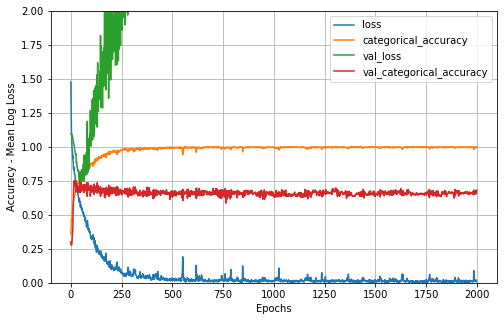

In [23]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [24]:
history.params

{'verbose': 1, 'epochs': 2000, 'steps': 8}

In [25]:
results[-1:]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
1999,0.007896,0.998367,2.877288,0.678879


In [26]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.9983668923377991


In [27]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.6788793206214905


#### Let's see how the model predicts using the development test set:

In [28]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[[1.  , 0.  , 0.  ]],

       [[1.  , 0.  , 0.  ]],

       [[1.  , 0.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 0.55, 0.45]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.03, 0.45, 0.52]],

       [[0.  , 0.01, 0.99]],

       [[0.  , 1.  , 0.  ]],

       [[0.01, 0.99, 0.  ]],

       [[0.29, 0.69, 0.02]],

       [[0.  , 1.  , 0.  ]],

       [[0.01, 0.99, 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]]], dtype=float32)

In [29]:
dev_predictions[:,0,:][:20]

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.55, 0.45],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.03, 0.45, 0.52],
       [0.  , 0.01, 0.99],
       [0.  , 1.  , 0.  ],
       [0.01, 0.99, 0.  ],
       [0.29, 0.69, 0.02],
       [0.  , 1.  , 0.  ],
       [0.01, 0.99, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ]], dtype=float32)

In [30]:
dev_rounded_predictions=np.round(dev_predictions[:,0,:])
indices = np.argmax(dev_predictions[:,0,:],1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [31]:
y_dev[:20, 0, :]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [32]:
dev_correct_predictions = np.equal(np.argmax(dev_predictions [:,0,:],1),np.argmax(y_dev[:,0,:],1))
print (dev_correct_predictions[:20])

[False False False  True  True  True  True  True False False False False
  True  True  True  True  True  True  True  True]


In [33]:
from collections import Counter
Counter(dev_correct_predictions)

Counter({False: 298, True: 630})

### 9. Save model

We save the model if it is better than others 

In [34]:
# Save
model.save('./Modelos/EGG_prac1_RNN_model3.h5') # Change the name in each model

In [ ]:
# Extract
"""
new_model = keras.models.load_model('path_to_my_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

### 10 - Final Test

#### 10.1 - Load the final test set

In [35]:
"""
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
users = ["0091", "0092", "0093"] # SE PUEDE CAMBIAR
"""

In [36]:
"""
def readRegisterAndReturnXy(user, total_records, task1, task2, task3 = ""):
    lTaskData = []
    for i_rec in range(1,total_records+1):
            record = "userS"+user+"f"+str(i_rec)+".mat"
            output = read_outputs(record) # output.task será y, output.data será x

            if task3 != "":
                outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
            else: 
                outT = (output.task == task1) | (output.task == task2)
            outData = output.data[outT[:,0],0:np.shape(output.data)[1]]

            outTask = output.task[outT[:,0]]
            outTD = OutTaskData(outTask, outData)
            lTaskData.append(outTD)

    X_test, y_test = [],[]
    for j in range(0,total_records):
        X_test.extend(lTaskData[j].data)
        y_test.extend(lTaskData[j].task)

    X_test = np.array(X_test)
    y_test = np.ravel(np.array(y_test))

    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)

    # ONE HOT ENCODER
    encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
    y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

    print("ONE HOT ENCODER:")
    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)
    
    return X_test, y_test
"""

In [37]:
"""
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)


"""

'\nn_final_test = n_instances-n_train-n_dev\n\nx_final_test = attributes.values[n_train+n_dev:n_instances]\nt_final_test = label.values[n_train+n_dev:n_instances]\n\nprint ("x_test:",x_final_test.shape)\nprint ("t_test:",t_final_test.shape)\n\n\n'

#### 10.2 - Evaluate the model

In [39]:
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

In [40]:
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 122, 123, 127)
    print(u, accuracy, success)
    print()

USER: 0091
29/29 [==============================] - 0s 1ms/step - loss: 2.8662 - categorical_accuracy: 0.6630
[[[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]]

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
<class 'numpy.ndarray'>


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
#model.evaluate(x_final_test, t_final_test) # Un 77 es un accuracy bajo 

The outputs computed by the neural network for the final testing dataset.

In [ ]:
"""
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]
"""

The target outputs.

In [ ]:
# t_final_test[:20]

The first 30 predictions. True means that the neural network correctly classifies the input vector.

In [ ]:
# test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
# test_correct_predictions[:30]

#### The final test accuracy.

In [ ]:
"""from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results"""

In [ ]:
#final_test_prediction_results[True]/sum(final_test_prediction_results.values())